In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.feature_column as fc 

In [2]:
%matplotlib inline

In [3]:
tf.__version__

'2.0.0-alpha0'

#### Download data from kaggle

In [4]:
!mkdir -p data
!kaggle competitions download -c titanic -p data

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
TRAIN_PATH = os.path.join('data', 'train.csv')
TEST_PATH = os.path.join('data', 'test.csv')

MODEL_DIR = os.path.join('model')
EXPORT_DIR = os.path.join('savedmodel')

In [6]:
CATEGORICAL_COLUMNS = ['Sex']
NUMERIC_COLUMNS = ['Pclass', 'Fare']
BUCKETIZED_COLUMNS = ['Age']
FEATURES_COLUMNS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS + BUCKETIZED_COLUMNS
TARGETS = 'Survived'
FEATURES_COLUMNS

['Sex', 'Pclass', 'Fare', 'Age']

In [99]:
FEATURE_CLIP_TRANS = ['Fare']
FEATURE_LOG1P_TRANS = ['Fare']
FEATURE_MIN_MAX_NORM = NUMERIC_COLUMNS

In [53]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [55]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df[TARGETS])

In [56]:
df_train.shape, df_valid.shape, df_test.shape

((712, 12), (179, 12), (418, 11))

In [32]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Define `input_fn`

In [33]:
def input_fn(df, batch_size=10, num_epochs=None, shuffle=False, is_inference=False):
    
    features = df[FEATURES_COLUMNS]
    features = {key: np.array(value) for key, value in dict(features).items()}

    if not is_inference:
        targets = df[TARGETS]
        pairs = (features, targets)
    else:
        pairs = features

    ds = tf.data.Dataset.from_tensor_slices(pairs) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    return ds

In [94]:
ds = input_fn(df_train)
ds

<RepeatDataset shapes: ({Sex: (None,), Pclass: (None,), Fare: (None,), Age: (None,)}, (None,)), types: ({Sex: tf.string, Pclass: tf.int64, Fare: tf.float64, Age: tf.float64}, tf.int32)>

In [36]:
for i, sample in enumerate(ds.take(2)):
    print('-- sample index: {}'.format(i))
    for f in FEATURES_COLUMNS:
        print('---- feature {}: {}'.format(f, sample[0][f]))
    
    print('---- targets: {}'.format(sample[1]))

-- sample index: 0
---- feature Sex: [b'male' b'female' b'female' b'female' b'male' b'male' b'male' b'male'
 b'female' b'female']
---- feature Pclass: [3 1 3 1 3 3 1 3 3 2]
---- feature Fare: [ 7.25   71.2833  7.925  53.1     8.05    8.4583 51.8625 21.075  11.1333
 30.0708]
---- feature Age: [22. 38. 26. 35. 35. nan 54.  2. 27. 14.]
---- targets: [0 1 1 1 0 0 0 0 1 1]
-- sample index: 1
---- feature Sex: [b'female' b'female' b'male' b'male' b'female' b'female' b'male' b'male'
 b'female' b'female']
---- feature Pclass: [3 1 3 3 3 2 3 2 3 3]
---- feature Fare: [16.7    26.55    8.05   31.275   7.8542 16.     29.125  13.     18.
  7.225 ]
---- feature Age: [ 4. 58. 20. 39. 14. 55.  2. nan 31. nan]
---- targets: [1 1 0 0 0 1 0 1 0 1]


In [37]:
train_input_fn = functools.partial(input_fn, df_train, batch_size=64, num_epochs=100, shuffle=True)
eval_input_fn = functools.partial(input_fn, df_valid, batch_size=64, num_epochs=1, shuffle=False)
predict_input_fn = functools.partial(input_fn, df_test, batch_size=64, num_epochs=1, shuffle=False, is_inference=True)

In [61]:
def norm(tensor, feature_name, df, 
         clip_list=FEATURE_CLIP_TRANS, 
         log1p_list=FEATURE_LOG1P_TRANS, 
         minmax_list=FEATURE_MIN_MAX_NORM):
    
    df = df.copy(deep=True)
    
    if feature_name in clip_list:
        lower, upper = df[feature_name].quantile([0.05, 0.95])
        df[feature_name] = df[feature_name].clip(lower=lower, upper=upper)
        lower_b = tf.broadcast_to(tf.cast(lower, tensor.dtype), tf.shape(tensor))
        upper_b = tf.broadcast_to(tf.cast(upper, tensor.dtype), tf.shape(tensor))
        tensor = tf.where(tf.greater_equal(tensor, lower_b), tensor, lower_b)
        tensor = tf.where(tf.less_equal(tensor, upper_b), tensor, upper_b)

    if feature_name in log1p_list:
        df[feature_name] = np.log1p(df[feature_name])
        tensor = tf.math.log1p(tf.cast(tensor, tf.float32))
        
    if feature_name in minmax_list:
        min_val, max_val = df[feature_name].min(), df[feature_name].max()
        range_val = max_val - min_val
        tensor = tf.truediv(
            tf.subtract(tensor, tf.cast(min_val, tensor.dtype)), 
            tf.cast(range_val, tensor.dtype))
    
    return tensor

In [62]:
BUCKET_QUANTILES = [0.2, 0.4, 0.6, 0.8]
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocab = df_train[feature_name].unique()
    feature_columns.append(
        fc.indicator_column(
            fc.categorical_column_with_vocabulary_list(feature_name, vocab, num_oov_buckets=1)))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        fc.numeric_column(
            feature_name, default_value=0.0, dtype=tf.float32, 
            normalizer_fn=lambda x, feature_name=feature_name, df=df_train: norm(x, feature_name, df)
        ))
    
for feature_name in BUCKETIZED_COLUMNS:
    fc_num_to_bucket = fc.numeric_column(feature_name, default_value=0.0, dtype=tf.float32)
    feature_columns.append(
        fc.bucketized_column(
            fc_num_to_bucket,
            boundaries=df_train[feature_name].quantile(BUCKET_QUANTILES).values.tolist()
        ))

In [63]:
feature_columns 

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=1)),
 NumericColumn(key='Pclass', shape=(1,), default_value=(0.0,), dtype=tf.float32, normalizer_fn=<function <lambda> at 0x1a36d2d048>),
 NumericColumn(key='Fare', shape=(1,), default_value=(0.0,), dtype=tf.float32, normalizer_fn=<function <lambda> at 0x1a36d2dea0>),
 BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=(0.0,), dtype=tf.float32, normalizer_fn=None), boundaries=(19.0, 25.0, 32.0, 41.200000000000045))]

In [64]:
def demo(feature_columns, take=2):
    input_layer = tf.keras.layers.DenseFeatures(feature_columns)
    for feature_batch, label_batch in ds.take(take):
        print(input_layer(feature_batch).numpy().shape)
        print(input_layer(feature_batch).numpy())
        

# The columnthe output maxtrix is sorted alphabetically by feature keys,  
# not necessarily the same as order of actual items in `feature_columns` list
demo(feature_columns)  

(10, 10)
[[0.         1.         0.         0.         0.         0.00580058
  1.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.8303865
  0.         0.         1.         0.        ]
 [0.         0.         1.         0.         0.         0.03567921
  1.         0.         1.         0.        ]
 [0.         0.         0.         1.         0.         0.72029936
  0.         0.         1.         0.        ]
 [0.         0.         0.         1.         0.         0.04096339
  1.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.05772879
  1.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.71150786
  0.         1.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.3797371
  1.         1.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.15235384
  1. 

In [65]:
linear_estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    model_dir=MODEL_DIR
)

In [66]:
linear_estimator.train(train_input_fn)

W0310 19:05:04.671244 4586862016 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0310 19:05:05.027771 4586862016 deprecation.py:506] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [67]:
linear_estimator.get_variable_names()

['global_step',
 'linear/linear_model/Age_bucketized/weights',
 'linear/linear_model/Age_bucketized/weights/part_0/Ftrl',
 'linear/linear_model/Age_bucketized/weights/part_0/Ftrl_1',
 'linear/linear_model/Fare/weights',
 'linear/linear_model/Fare/weights/part_0/Ftrl',
 'linear/linear_model/Fare/weights/part_0/Ftrl_1',
 'linear/linear_model/Pclass/weights',
 'linear/linear_model/Pclass/weights/part_0/Ftrl',
 'linear/linear_model/Pclass/weights/part_0/Ftrl_1',
 'linear/linear_model/Sex_indicator/weights',
 'linear/linear_model/Sex_indicator/weights/part_0/Ftrl',
 'linear/linear_model/Sex_indicator/weights/part_0/Ftrl_1',
 'linear/linear_model/bias_weights',
 'linear/linear_model/bias_weights/part_0/Ftrl',
 'linear/linear_model/bias_weights/part_0/Ftrl_1']

In [68]:
linear_estimator.get_variable_value('linear/linear_model/Fare/weights')

array([[0.11112831]], dtype=float32)

In [69]:
linear_estimator.get_variable_value('linear/linear_model/Age_bucketized/weights')

array([[0.30800885],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [70]:
linear_estimator.get_variable_value('linear/linear_model/bias_weights')

array([0.30800873], dtype=float32)

In [71]:
result = linear_estimator.evaluate(eval_input_fn)

W0310 19:05:27.897464 4586862016 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [72]:
result

{'accuracy': 0.7765363,
 'accuracy_baseline': 0.61452514,
 'auc': 0.8239789,
 'auc_precision_recall': 0.7615255,
 'average_loss': 0.49212372,
 'label/mean': 0.38547486,
 'loss': 0.48964646,
 'precision': 0.79591835,
 'prediction/mean': 0.33180472,
 'recall': 0.5652174,
 'global_step': 1200}

In [73]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [98]:
pred_dicts = list(linear_estimator.predict(predict_input_fn))
pred_dicts[:2]

[{'logits': array([-2.5888593], dtype=float32),
  'logistic': array([0.06985888], dtype=float32),
  'probabilities': array([0.93014115, 0.06985886], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object)},
 {'logits': array([-0.02497429], dtype=float32),
  'logistic': array([0.49375674], dtype=float32),
  'probabilities': array([0.5062432 , 0.49375674], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object)}]

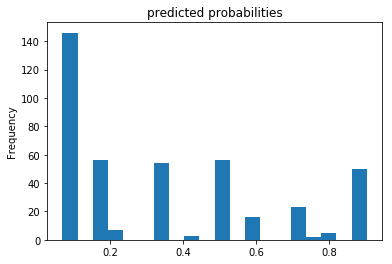

In [76]:
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
classes = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [95]:
probs[:5]

0    0.069859
1    0.493757
2    0.161132
3    0.070107
4    0.498948
dtype: float64

Export to SavedModel  
You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python.

In [78]:
features_raw_placeholder = {
    'Sex': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.string, name='input_sex'),
    'Pclass': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.float32, name='input_pclass'),
    'Fare': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.float32, name='input_fare'),
    'Age': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.float32, name='input_age')
}

serving_raw_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    features=features_raw_placeholder)

export_path = linear_estimator.export_saved_model(
    EXPORT_DIR, serving_raw_input_fn)

W0310 19:06:32.411674 4586862016 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0310 19:06:32.412666 4586862016 tf_logging.py:161] Export includes no default signature!


In [ ]:
# serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
#     fc.make_parse_example_spec(feature_columns))

# export_path = linear_estimator.export_saved_model(
#     EXPORT_DIR, serving_input_fn)

In [ ]:
# %%bash
# SAVEDMODEL=/Users/jameswong/WorkingDirectory/Python/labs/tf2/savedmodel/
# docker run -t --rm --name tf -p 8501:8501 -v "$SAVEDMODEL:/models/model" tensorflow/serving 

In [ ]:
# curl -d '{"signature_name":"predict","instances":["", ""]}' \
# -X POST http://localhost:8501/v1/models/model:predict      

curl -d '{"signature_name":"predict","inputs":{"Sex": ["male", "female"], "Pclass": [3, 3], "Fare": [7.8292,7.0000], "Age": [34.5, 47]}}' \
-X POST http://localhost:8501/v1/models/model:predict             
            

In [91]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [80]:
import requests

In [89]:
data = '{"signature_name": "predict", "inputs": {"Sex": ["male", "female"], "Pclass": [3, 3], "Fare": [7.8292,7.0000], "Age": [34.5, 47]}}'
url = 'http://localhost:8501/v1/models/model/versions/1552215992:predict'
response = requests.post(url, data=data)

if response.ok:
    print(response.json())
    

{'outputs': {'classes': [['0'], ['0']], 'logits': [[-2.58886], [-0.0249743]], 'logistic': [[0.0698589], [0.493757]], 'class_ids': [[0], [0]], 'probabilities': [[0.930141, 0.0698589], [0.506243, 0.493757]]}}
